In [1]:
"""

Ref: https://blog.collegefootballdata.com/talking-tech-building-an-artifical-neural-network-to/

"""
import cfbd
import numpy as np
import pandas as pd
import os
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, KFold, cross_validate
import optuna
import pickle
from datetime import datetime

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

c:\Users\Kyle\Documents\Projects\staturdays\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train, X_test, y_train, y_test = (
    pd.read_parquet(path="./data/X_train.parquet"),
    pd.read_parquet(path="./data/X_test.parquet"),
    pd.read_parquet(path="./data/y_train.parquet"),
    pd.read_parquet(path="./data/y_test.parquet"),
)

In [6]:
exclude = [
    "id",
    "season",
    "year",
    "season_type",
    "start_date",
    "completed",
    "home_ml",
    "away_ml",
    "spread_open",
    "over_under_open",
    "team_home",
    "team_away",
    "home_post_wp",
    "away_post_wp",
    "home_team",
    "away_team",
    "home_points",
    "away_points",
    # "srs_rating_home",
    # "srs_ranking_home",
    # "srs_rating_away",
    # "srs_ranking_away",
]

# Training

In [7]:
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [8]:
# Model
lgbm_reg = lgbm.LGBMRegressor(
    # constants
    boosting_type="gbdt",
    learning_rate=0.001,
    n_estimators=10000,
    objective="mae",
    random_state=0,
    early_stopping_round=10,
    # tuned
    reg_alpha=3.9740293140705107,
    reg_lambda=1.881540488130314,
    colsample_bytree=1.0,  # percent of features to randomly select for use on each tree
    subsample=0.6,  # percent of data to sample without resampling. only works if bagging_freq is also set
    bagging_freq=1,  # bag by subsample every kth tree
    max_depth=4,
    num_leaves=873,  # should be less than 2^max_depth. Should be significantly less to avoid overfitting
    min_child_samples=42,
    min_data_per_groups=92,
    # meta
    force_col_wise=True,
)

lgbm_reg.fit(
    X=X_tr.drop(columns=exclude),
    y=y_tr,
    eval_set=(X_v.drop(columns=exclude), y_v),
)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Total Bins 17456
[LightGBM] [Info] Number of data points in the train set: 4767, number of used features: 82
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Start training from score -6.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

LGBMRegressor(bagging_freq=1, early_stopping_round=10, force_col_wise=True,
              learning_rate=0.001, max_depth=4, min_child_samples=42,
              min_data_per_groups=92, n_estimators=10000, num_leaves=873,
              objective='mae', random_state=0, reg_alpha=3.9740293140705107,
              reg_lambda=1.881540488130314, subsample=0.6)

# Eval

Feature Importance

In [9]:
feat_imp = pd.DataFrame(
    {"feat": lgbm_reg.feature_name_, "imp": lgbm_reg.feature_importances_}
).sort_values(by="imp", ascending=False)

<Axes: ylabel='feat'>

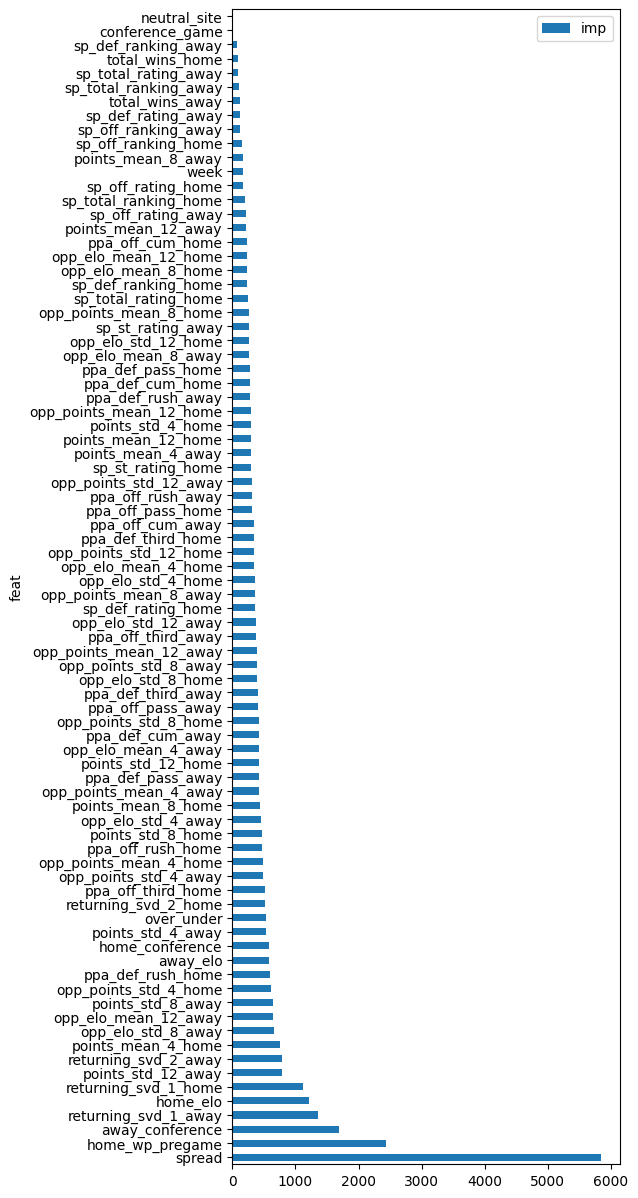

In [10]:
feat_imp.plot(x="feat", y="imp", kind="barh", figsize=(5, 15))

In [11]:
y_preds = lgbm_reg.predict(X_test.drop(columns=exclude))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [12]:
y_preds = pd.Series(y_preds, name="preds")

In [13]:
eval_df = pd.DataFrame(
    {"preds": y_preds, "actual": y_test["margin"].reset_index(drop=True)}
)
eval_df["mae"] = abs(eval_df["preds"] - eval_df["actual"])
eval_df["mae"].describe()

count    799.000000
mean      12.466536
std        9.325832
min        0.004976
25%        5.010857
50%       10.475254
75%       17.839621
max       48.741601
Name: mae, dtype: float64

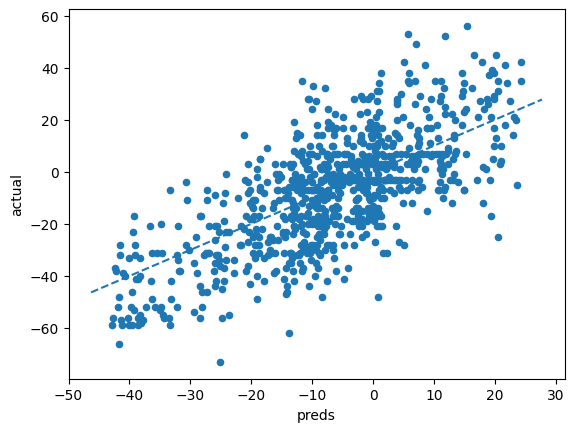

In [14]:
import matplotlib.pyplot as plt
import numpy as np


def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, "--")


eval_df.plot(x="preds", y="actual", kind="scatter")
abline(1, 0)

<Axes: xlabel='bucket'>

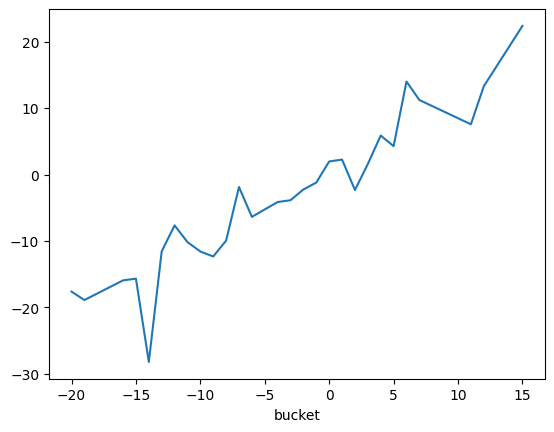

In [15]:
eval_df.assign(bucket=round(eval_df["preds"], 0)).groupby("bucket")["actual"].agg(
    ["mean", "count"]
).query("count > 10")["mean"].plot()

Compare to straight up, ATS.

In [16]:
eval_df["spread"] = X_test.spread.reset_index(drop=True)
eval_df["spread_mae"] = abs(eval_df["spread"] - eval_df["actual"])
eval_df.filter(like="mae").describe()

,mae,spread_mae
count,799.000000,784.000000
mean,12.466536,12.172194
std,9.325832,9.257544
min,0.004976,0.000000
25%,5.010857,5.000000
50%,10.475254,10.500000
75%,17.839621,17.125000
max,48.741601,59.000000


Straight Up

Model:

In [17]:
straight_up = (np.sign(eval_df["preds"]) == np.sign(eval_df["actual"])).sum() / len(
    eval_df
)

Spread:

In [18]:
straight_up_vs_spread = straight_up - (
    (np.sign(eval_df["spread"]) == np.sign(eval_df["actual"])).sum() / len(eval_df)
)

ATS

In [19]:
ats = (
    abs(eval_df["preds"] - eval_df["actual"])
    < abs(eval_df["spread"] - eval_df["actual"])
).sum() / len(eval_df["spread"].dropna())

Log Model Results

In [20]:
date = format(datetime.today(), "%Y-%m-%d-%H-%M")
model_name = f"model-{date}"

In [21]:
eval_dict = {
    "best_mae": lgbm_reg.best_score_["valid_0"]["l1"],
    "ats": ats,
    "straight_up": straight_up,
    "straight_up_vs_spread": straight_up_vs_spread,
    "top_feats": feat_imp.head(10),
}

eval_dict

{'best_mae': 12.953712584274628,
 'ats': 0.49362244897959184,
 'straight_up': 0.7509386733416771,
 'straight_up_vs_spread': 0.007509386733416723,
 'top_feats':                     feat   imp
 8                 spread  5852
 43       home_wp_pregame  2428
 5        away_conference  1695
 11  returning_svd_1_away  1354
 4               home_elo  1213
 9   returning_svd_1_home  1116
 77    points_std_12_away   794
 12  returning_svd_2_away   787
 45    points_mean_4_home   754
 75    opp_elo_std_8_away   656}

In [22]:
with open(f"./models/eval-{model_name}.txt", "w") as f:
    f.write(str(eval_dict))

# Hyperparam Tuning

In [27]:
iter = []

from sklearn.metrics import mean_absolute_error


def objective(trial, X=X_train, y=y_train, data=None, target=None):
    param = {
        "metric": "mae",
        "random_state": 0,
        "n_estimators": 10000,
        "learning_rate": 0.001,
        "subsample_freq": 1,
        "early_stopping_rounds": 10,
        "force_col_wise": True,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1, 2, 3, 5, 10]),
        "max_depth": trial.suggest_int("max_depth", 1, 6),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
        "min_data_per_group": trial.suggest_int("min_data_per_group", 1, 100),
        "cat_smooth": trial.suggest_float("cat_smooth", 1e-3, 25),
    }
    model = lgbm.LGBMRegressor(**param, verbosity=-1)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    avg_mae = []
    avg_iter = []

    for i, (train_index, test_index) in enumerate(kf.split(X=X, y=y)):
        X_test, y_test = X.loc[test_index, :], y.loc[test_index, :]
        X_train, y_train = X.loc[train_index, :], y.loc[train_index, :]

        model.fit(
            X_train.drop(columns=exclude),
            y_train,
            eval_set=[(X_test.drop(columns=exclude), y_test)],
        )

        avg_iter.append(model.best_iteration_)

        preds = model.predict(X_test.drop(columns=exclude))

        mae = mean_absolute_error(y_true=y_test, y_pred=preds)

        avg_mae.append(mae)

    # Avg. results over K folds
    avg_mae = np.mean(avg_mae)
    avg_iter = np.mean(avg_iter)

    # Save avg. number of rounds for reference
    iter.append(avg_iter)

    return avg_mae

In [32]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2023-09-23 15:10:55,603] A new study created in memory with name: no-name-abea05e5-0955-4a8f-acae-21e5a5140c3c
[I 2023-09-23 15:11:12,558] Trial 0 finished with value: 12.915298039664098 and parameters: {'reg_alpha': 0.005483655804847852, 'reg_lambda': 0.0010755430266964176, 'colsample_bytree': 0.6, 'subsample': 0.2, 'bagging_freq': 10, 'max_depth': 6, 'num_leaves': 863, 'min_child_samples': 43, 'min_data_per_group': 98, 'cat_smooth': 14.670162166385923}. Best is trial 0 with value: 12.915298039664098.
[I 2023-09-23 15:11:23,801] Trial 1 finished with value: 12.917211247107527 and parameters: {'reg_alpha': 0.007897729575521728, 'reg_lambda': 0.2317886010718418, 'colsample_bytree': 0.8, 'subsample': 0.3, 'bagging_freq': 1, 'max_depth': 1, 'num_leaves': 434, 'min_child_samples': 6, 'min_data_per_group': 52, 'cat_smooth': 8.920780498832725}. Best is trial 0 with value: 12.915298039664098.
[I 2023-09-23 15:11:33,724] Trial 2 finished with value: 12.882573919137343 and parameters: {'reg_

Number of finished trials: 25
Best trial: {'reg_alpha': 2.510693484819741, 'reg_lambda': 0.005050695732940717, 'colsample_bytree': 1.0, 'subsample': 0.6, 'bagging_freq': 1, 'max_depth': 4, 'num_leaves': 685, 'min_child_samples': 17, 'min_data_per_group': 7, 'cat_smooth': 0.365005025834078}


In [33]:
study.best_value

12.78456674525102

In [34]:
best_iter = iter[study.best_trial.number]
best_iter

3421.2

In [35]:
study.best_params

{'reg_alpha': 2.510693484819741,
 'reg_lambda': 0.005050695732940717,
 'colsample_bytree': 1.0,
 'subsample': 0.6,
 'bagging_freq': 1,
 'max_depth': 4,
 'num_leaves': 685,
 'min_child_samples': 17,
 'min_data_per_group': 7,
 'cat_smooth': 0.365005025834078}

# Retrain with updated hyperparams

In [36]:
# Model
lgbm_reg = lgbm.LGBMRegressor(
    # constants
    boosting_type="gbdt",
    learning_rate=0.001,
    n_estimators=10000,
    objective="mae",
    random_state=0,
    early_stopping_round=10,
    # tuned
    **study.best_params,
    # meta
    force_col_wise=True,
)

lgbm_reg.fit(
    X=X_tr.drop(columns=exclude),
    y=y_tr,
    eval_set=(X_v.drop(columns=exclude), y_v),
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Total Bins 17456
[LightGBM] [Info] Number of data points in the train set: 4767, number of used features: 82
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Start training from score -6.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(bagging_freq=1, cat_smooth=0.365005025834078,
              early_stopping_round=10, force_col_wise=True, learning_rate=0.001,
              max_depth=4, min_child_samples=17, min_data_per_group=7,
              n_estimators=10000, num_leaves=685, objective='mae',
              random_state=0, reg_alpha=2.510693484819741,
              reg_lambda=0.005050695732940717, subsample=0.6)

## Confirm test results indeed improved

Score to beat

In [37]:
eval_df["mae"].describe()

count    799.000000
mean      12.466536
std        9.325832
min        0.004976
25%        5.010857
50%       10.475254
75%       17.839621
max       48.741601
Name: mae, dtype: float64

New results

In [38]:
y_preds = lgbm_reg.predict(X_test.drop(columns=exclude))
y_preds = pd.Series(y_preds, name="preds")
eval_df = pd.DataFrame(
    {"preds": y_preds, "actual": y_test["margin"].reset_index(drop=True)}
)
eval_df["mae"] = abs(eval_df["preds"] - eval_df["actual"])
eval_df["mae"].describe()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


count    799.000000
mean      12.501837
std        9.313255
min        0.065132
25%        5.162881
50%       10.614956
75%       18.023420
max       48.748332
Name: mae, dtype: float64

# Retrain Model on Full Data

In [39]:
# Join train, valid, and test
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [41]:
# Train
# Model
lgbm_reg = lgbm.LGBMRegressor(
    # constants
    boosting_type="gbdt",
    learning_rate=0.001,
    n_estimators=round(best_iter),
    objective="mae",
    random_state=0,
    # tuned
    **study.best_params,
    # meta
    force_col_wise=True,
)

lgbm_reg.fit(
    X=X.drop(columns=exclude),
    y=y,
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Total Bins 17522
[LightGBM] [Info] Number of data points in the train set: 6758, number of used features: 82
[LightGBM] [Info] Start training from score -6.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

LGBMRegressor(bagging_freq=1, cat_smooth=0.365005025834078, force_col_wise=True,
              learning_rate=0.001, max_depth=4, min_child_samples=17,
              min_data_per_group=7, n_estimators=3421, num_leaves=685,
              objective='mae', random_state=0, reg_alpha=2.510693484819741,
              reg_lambda=0.005050695732940717, subsample=0.6)

# Save Model

In [42]:
with open(f"./models/{model_name}.pickle", "wb") as f:
    pickle.dump(lgbm_reg, f)